In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

## Load IMDB dataset

In [2]:
VOCAB_SIZE = 10000

(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.imdb.load_data(num_words=VOCAB_SIZE)

print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))
print("Length examples: {}".format([len(train_data[0]), len(train_data[1])]))
print("Entry example: {}".format(train_data[0]))

Training entries: 25000, labels: 25000
Length examples: [218, 189]
Entry example: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 1

## Define encode/decode functions (using word2idx, idx2word)

In [3]:
word_index = tf.keras.datasets.imdb.get_word_index()

word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

def encode_review(text):
    words = text.lower().split()
    words = ['<START>'] + words
    idxs = [word_index.get(word, word_index['<UNK>']) for word in words]
    return idxs

print('Example of a decoded review: \n{}'.format(decode_review(train_data[0])))

Example of a decoded review: 
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing

In [4]:
text = 'hello world'

encode_review(text)
decode_review(encode_review(text))

'<START> hello world'

## Pad all sequences to the same length

In [5]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256)

print("Length examples: {}".format([len(train_data[0]), len(train_data[1])]))
print("Entry example: {}".format(train_data[0]))

Length examples: [256, 256]
Entry example: [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   1

## Build a keras model

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


## Prepare model for training

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

## Split dataset into train and validation subsets

In [8]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Run the training procedure

In [9]:
BATCH_SIZE = 512
NUM_EPOCHS = 40

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 60us/sample - loss: 0.6916 - acc: 0.5329 - val_loss: 0.6897 - val_acc: 0.5599
Epoch 2/40
15000/15000 [==============================] - 0s 15us/sample - loss: 0.6856 - acc: 0.6764 - val_loss: 0.6815 - val_acc: 0.7134
Epoch 3/40
15000/15000 [==============================] - 0s 15us/sample - loss: 0.6728 - acc: 0.7374 - val_loss: 0.6653 - val_acc: 0.7534
Epoch 4/40
15000/15000 [==============================] - 0s 16us/sample - loss: 0.6503 - acc: 0.7559 - val_loss: 0.6397 - val_acc: 0.7630
Epoch 5/40
15000/15000 [==============================] - 0s 16us/sample - loss: 0.6174 - acc: 0.7884 - val_loss: 0.6054 - val_acc: 0.7845
Epoch 6/40
15000/15000 [==============================] - 0s 15us/sample - loss: 0.5758 - acc: 0.8111 - val_loss: 0.5654 - val_acc: 0.8017
Epoch 7/40
15000/15000 [==============================] - 0s 15us/sa

## Evaluate the model on the test dataset

In [10]:
results = model.evaluate(test_data, test_labels)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

25000/25000 [==============================] - 1s 55us/sample - loss: 0.3293 - acc: 0.8716
Test loss: 0.3293
Test accuracy: 87.16 %%


## Plot train/validation loss and accuracy

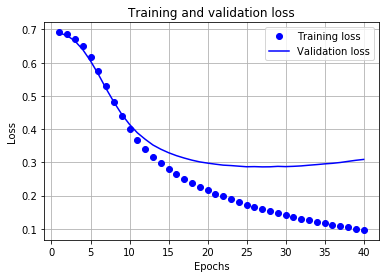

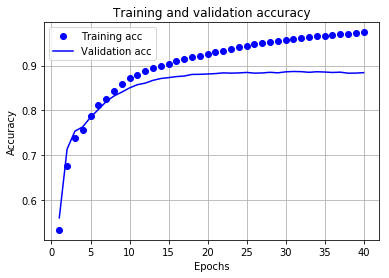

In [11]:
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

## Test the model on my sequence

In [12]:
text = 'It was a really good movie it was so fantastic'

encoded = encode_review(text)
prediction = model.predict(np.array(encoded)[None, :])[0,0]

print(prediction)
print('Positive' if prediction > 0.5 else 'Negative')

0.9999665
Positive
